In [28]:
import tensorflow as tf
import numpy as np
from keras import Model
from keras.layers import Conv2D,MaxPool2D,ZeroPadding2D,GlobalAveragePooling2D,AveragePooling2D
from keras.layers import Flatten,Dense,BatchNormalization,Add,Activation,concatenate,Input
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from keras.preprocessing import image
gpus=tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [29]:
#Importing Data
train_dir=r'C:\Users\soumi\OneDrive\Desktop\Project_sample\train_dir'
test_dir=r'C:\Users\soumi\OneDrive\Desktop\Project_sample\test_dir'
valid_dir=r'C:\Users\soumi\OneDrive\Desktop\Project_sample\test_dir'

In [30]:
#Rescaling and augmentation of data
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224,224,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
],name="data_augmentation")

In [31]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
training_set=tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode = 'categorical',
    shuffle=False
)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = valid_dir,
    image_size = IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode = 'categorical',
)
class_names=validation_set.class_names

Found 210 files belonging to 10 classes.
Found 57 files belonging to 10 classes.
Found 57 files belonging to 10 classes.


In [32]:
def conv_bn(x,filters,row,col,padding='same',strides=(1,1)):
    x=Conv2D(filters,(row,col),strides=strides,padding=padding)(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation('relu')(x)
    return x

In [33]:
def inc_block_a(x):
    c1x1=conv_bn(x,64,1,1)
    c3x3=conv_bn(x,48,1,1)
    c3x3=conv_bn(c3x3,64,3,3)
    c5x5=conv_bn(x,64,1,1)
    c5x5=conv_bn(c5x5,96,3,3)
    c5x5=conv_bn(c5x5,96,3,3)
    mpool=MaxPool2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    mpool=conv_bn(mpool,32,1,1)
    x=concatenate([c1x1,c3x3,c5x5,mpool],axis=3)
    return x

In [34]:
def reduction_block_a(x):
    mpool=MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
    c3x3=conv_bn(x,384,3,3,strides=(2,2),padding='valid')
    c1_3x3=conv_bn(x,64,1,1)
    c1_3x3=conv_bn(c1_3x3,96,3,3)
    c1_3x3=conv_bn(c1_3x3,96,3,3,strides=(2,2),padding='valid')
    x=concatenate([mpool,c3x3,c1_3x3])
    return x

In [35]:
def inc_block_b(x):
    c1x1=conv_bn(x,192,1,1)
    c_b1=AveragePooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    c_b1=conv_bn(c_b1,192,1,1)
    c_b2=conv_bn(x,128,1,1)
    c_b2=conv_bn(c_b2,128,1,7)
    c_b2=conv_bn(c_b2,192,7,1)
    c_b3=conv_bn(x,128,1,1)
    c_b3=conv_bn(c_b3,128,7,1)
    c_b3=conv_bn(c_b3,128,1,7)
    c_b3=conv_bn(c_b3,128,7,1)
    c_b3=conv_bn(c_b3,192,1,7)
    x=concatenate([c1x1,c_b1,c_b2,c_b3],axis=3)
    return x

In [36]:
def reduction_block_b(x):
    b1=MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
    b2=conv_bn(x,192,1,1)
    b2=conv_bn(b2,320,3,3,strides=(2,2),padding='valid')
    b3=conv_bn(x,192,1,1)
    b3=conv_bn(b3,192,1,7)
    b3=conv_bn(b3,192,7,1)
    b3=conv_bn(b3,192,3,3,strides=(2,2),padding='valid')
    x=concatenate([b1,b2,b3],axis=3)
    return x

In [37]:
def inc_block_c(x):
    b1=conv_bn(x,320,1,1)
    b2=conv_bn(x,384,1,1)
    b2_1x3=conv_bn(b2,384,1,3)
    b2_3x1=conv_bn(b2,384,3,1)
    b2=concatenate([b2_1x3,b2_3x1],axis=3)
    b3=conv_bn(x,448,1,1)
    b3_3x3=conv_bn(b3,384,3,3)
    b3_1x3=conv_bn(b3_3x3,384,1,3)
    b3_3x1=conv_bn(b3_3x3,384,3,1)
    b3=concatenate([b3_1x3,b2_3x1],axis=3)
    b4=AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
    b4=conv_bn(b4,192,1,1)
    x=concatenate([b1,b2,b3,b4],axis=3)
    return x

In [38]:
def Inceptionv3(input_shape=(224,224,3),classes=10):
    img_input=Input(input_shape)
    
    x=conv_bn(img_input,32,3,3,padding='valid',strides=(2,2))
    x=conv_bn(x,32,3,3,padding='valid')
    x=conv_bn(x,64,3,3)
    x=MaxPool2D(pool_size=(3,3),strides=(2,2))(x)

    x=inc_block_a(x)
    x=inc_block_a(x)
    x=inc_block_a(x)

    x=reduction_block_a(x)

    x=inc_block_b(x)
    x=inc_block_b(x)
    x=inc_block_b(x)
    x=inc_block_b(x)

    x=reduction_block_b(x) 
    
    x=inc_block_c(x)

    x=inc_block_c(x)

    x=GlobalAveragePooling2D(name='avg_pool')(x)

    x=Flatten()(x)

    x=Dense(units=2048,activation='relu')(x)

    x=Dense(units=classes,activation='softmax',name='predictions')(x)

    model=Model(img_input,x,name='Inceptionv3')

    return model

In [48]:
model=Inceptionv3(input_shape=(224,224,3),classes=10)

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint
#Checkpoint to save the best model per epoch
model_path=r'C:\Users\soumi\OneDrive\Desktop\Inceptionv3\Inc{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpoint=ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [50]:
model.summary()

Model: "Inceptionv3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_184 (Conv2D)         (None, 111, 111, 32)         896       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_184 (B  (None, 111, 111, 32)         128       ['conv2d_184[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_184 (Activation  (None, 111, 111, 32)         0         ['batch_normalizatio

In [51]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [53]:
#Training the model
history=model.fit(
    training_set, 
    epochs=150, 
    validation_data=test_set,
    batch_size=32,
    callbacks=[checkpoint],
)

Epoch 1/150
7/7 [==============================] - ETA: 0s - loss: 1.1041 - accuracy: 0.5762 
Epoch 1: val_loss did not improve from 54.38263
7/7 [==============================] - 183s 25s/step - loss: 1.1041 - accuracy: 0.5762 - val_loss: 95.7577 - val_accuracy: 0.2807
Epoch 2/150
7/7 [==============================] - ETA: 0s - loss: 0.9874 - accuracy: 0.6143 
Epoch 2: val_loss did not improve from 54.38263
7/7 [==============================] - 181s 25s/step - loss: 0.9874 - accuracy: 0.6143 - val_loss: 174.6904 - val_accuracy: 0.2281
Epoch 3/150
7/7 [==============================] - ETA: 0s - loss: 0.9759 - accuracy: 0.6333 
Epoch 3: val_loss did not improve from 54.38263
7/7 [==============================] - 180s 25s/step - loss: 0.9759 - accuracy: 0.6333 - val_loss: 59.5333 - val_accuracy: 0.2982
Epoch 4/150
7/7 [==============================] - ETA: 0s - loss: 1.0095 - accuracy: 0.6143 
Epoch 4: val_loss improved from 54.38263 to 34.39356, saving model to C:\Users\soumi\OneD

In [54]:
from tensorflow.keras.models import Model,load_model
model=load_model(r"C:\Users\soumi\OneDrive\Desktop\Inceptionv3\Inc29-0.3509.hdf5")

In [65]:
ar=np.empty(0)
for im,y in test_set:
    ar=np.append(ar,y)
yt=np.zeros((57,10))
count=0
for i in range(0,57):
    for j in range(5):
        yt[i][j]=ar[count]
        count+=1
yt=tf.convert_to_tensor(yt,dtype=tf.float32)
print(yt)
yt.shape

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

TensorShape([57, 10])

In [64]:
yp=model.predict(test_set)
arr=np.zeros(yp.shape)
for i in range(yp.shape[0]):
    for j in range(yp.shape[1]):
        c=yp[i].argmax()
        arr[i][c]=1
yp=arr
print(yp)
yp.shape

2/2 [==============================] - 6s 2s/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 

(57, 10)

In [66]:
accuracy=accuracy_score(yt,yp)
print('Accuracy=',accuracy)
precision=precision_score(yt,yp,average='macro')
print('Precision=',precision)
recall=recall_score(yt,yp,average='macro')
print('Recall=',recall)
f1=f1_score(yt,yp,average='macro')
print('F1 Score=',f1)

Accuracy= 0.017543859649122806
Precision= 0.01
Recall= 0.014285714285714285
F1 Score= 0.011764705882352941


C:\Users\soumi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\soumi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\soumi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

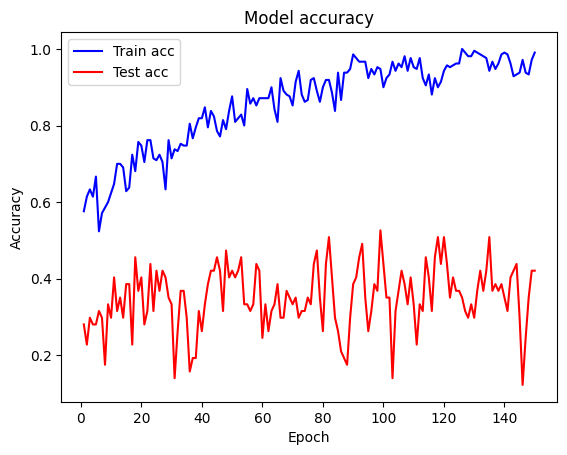

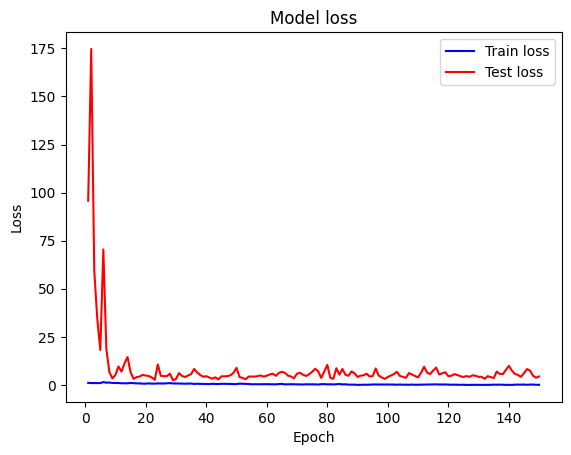

In [68]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Train acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image=tf.keras.utils.load_img(r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Images for checking\img.jpg',target_size=(224,224))
test_image=tf.keras.utils.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
result=result.flatten()
print(result)
print(class_names)
index=result.argmax()
confidence=result[index]*100;
pred_class=class_names[index]
if pred_class!='Groundnut__Healthy':
    print(f'The disease of the given groundnut leaf is {pred_class} predicted with {confidence} % confidence')
else:
    print(f'The groundnut leaf is healthy predicted with {confidence} % confidence')